In [37]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.TDEM import geteref, Problem3DIP_Linear, SurveyLinear
from simpegEMIP.TDEM import Survey, Rx
from simpegEMIP.TDEM import Problem3DEM_e, Problem3D_e
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver

eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
actinds = mesh.gridCC[:,2]<0.
layerind = (np.logical_and(mesh.gridCC[:,2]<0, mesh.gridCC[:,2]>-50.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[~actinds] = 1e-8
sigmaInf[layerind] = 0.1
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 1.
c = np.ones(mesh.nC) * 0.5

def get_em_data(sigma, eta=None, tau=None, c=None, data_type='em'):
    rxloc = np.array([[0., 0., 30.]])
    srcloc = np.array([[0., 0., 30.]])
    dt = 1.47e-3
    tpeak = 2.73e-3
    t0 = tpeak + dt
    rx_vtem = Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, orientation='z')
    src_vtem = EM.TDEM.Src.CircularLoop([rx_vtem], waveform=EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.), loc=srcloc)
    survey = Survey([src_vtem])
    if data_type == 'em':
        prb = Problem3DEM_e(mesh, sigma=sigma)
    elif data_type == 'emip':
        prb = Problem3D_e(mesh, sigmaInf=sigma, eta=eta, tau=tau, c=c)
    prb.timeSteps = [(tpeak/10, 10), ((t0-tpeak)/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb.Solver = PardisoSolver
    prb.pair(survey)
    e = prb.fields(sigmaInf)
    data = survey.dpred(sigmaInf, f=e)
    # waveform
    cur = []
    for t in prb.times:
        cur.append(src_vtem.waveform.eval(t))
    cur = np.hstack(cur)
    return e, data, cur

def get_ip_data(sigma, eref, eta, tau, c):
    rxloc = np.array([[0., 0., 30.]])
    srcloc = np.array([[0., 0., 30.]])    
    rx_ip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
    src_ip = EM.TDEM.Src.CircularLoop([rx_ip], loc=srcloc)
    dt = 1.47e-3
    tpeak = 2.73e-3
    t0 = tpeak + dt
    survey_ip = SurveyLinear([src_ip])
    t1, t2, t3 = dt, t0-0.001365, t0
    prb_ip = Problem3DIP_Linear(
        mesh, 
        sigmaInf=sigmaInf, 
        eta=eta, 
        tau=tau, 
        c=c, 
        actinds = actinds,
        tlags = [0., t1, t2, t3]
    )
    prb_ip.Solver = PardisoSolver
    prb_ip.pair(survey_ip)
    prb_ip.set_eref(eref)
    ip_approx = survey_ip.dpred([])
    return ip_approx

(-200, 200)

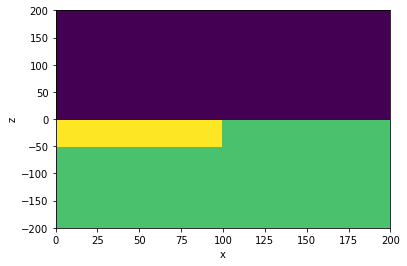

In [38]:
mesh.plotImage(np.log10(sigmaInf))
plt.xlim(0,200)
plt.ylim(-200,200)

In [39]:
%%time
e_emip, data_emip, cur = get_em_data(sigmaInf, eta, tau, c, data_type='emip')

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


CPU times: user 6.71 s, sys: 152 ms, total: 6.86 s
Wall time: 3.93 s


In [40]:
%%time
e_em, data_em, cur = get_em_data(sigmaInf)
eref = geteref(e_em[:,0,:], mesh, option=None, tInd=20) 
ip = get_ip_data(sigmaInf, eref, eta, tau, c)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


>> Compute Sensitivity matrix
 1 / 1CPU times: user 1.62 s, sys: 27.4 ms, total: 1.65 s
Wall time: 910 ms


/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


In [41]:
data = ip + data_em

In [42]:
times = np.logspace(np.log10(2e-5), np.log10(0.009), 51)

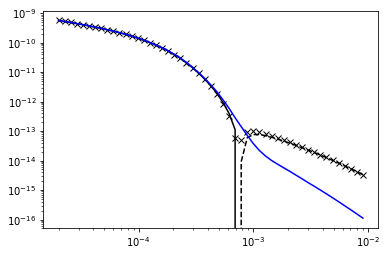

In [43]:
plt.loglog(times, -data, 'k')
plt.loglog(times, data, '--k')
plt.loglog(times, -data_emip, 'kx')
plt.loglog(times, data_emip, 'kx')
plt.loglog(times, -data_em, 'b')